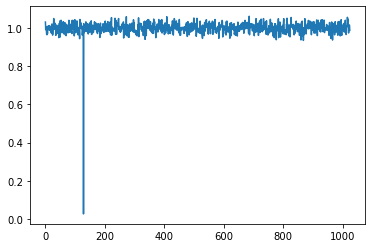

In [3]:
import cupy as cp
import numpy as np
import time
import logging

from astropy import units as u
import setigen as stg
import pandas as pd


import pylab as plt
# Logger setup
logger_name = 'hyperseti'
logger = logging.getLogger(logger_name)
logger.setLevel(logging.CRITICAL)
#logger.setLevel(logging.INFO)

spectral_kurtosis_kernel = cp.RawKernel(r'''
extern "C" __global__
    __global__ void spectralKurtosisKernel
        (const float *data, float *kurtosis, int F, int T)
        /* Each thread computes a different dedoppler sum for a given channel
        
         F: N_frequency channels
         T: N_time steps
        
         *data: Data array, (T x F) shape
         *kurtosis: Dedoppler summed data, (D x F) shape
        */
        {
        
        // Setup thread index
        const int tid = blockIdx.x * blockDim.x + threadIdx.x;

        // Index for output array
        int idx = 0;        
        float S1 = 0;
        float S2 = 0;
        
        for (int t = 0; t < T; t++) {
                          // timestep    
            idx  = tid + (F * t);  
            if (idx < F * T) {
                S1 += data[idx];
                S2 += data[idx] * data[idx];
              }
              kurtosis[tid] = (T+1)/(T-1) * (T*(S2/(S1*S1)) - 1);
            }
        }
''', 'spectralKurtosisKernel')


def spectral_kurtosis(data, return_space='gpu'):
    """ Compute spectral kurtosis """
    
    # Compute minimum possible drift (delta_dd)
    N_time, N_chan = data.shape

    # Copy data over to GPU
    d_gpu = cp.asarray(data.astype('float32'))
    
    # Allocate GPU memory for dedoppler data
    kurtosis_gpu = cp.zeros(N_chan, dtype=cp.float32)
    
    # Setup grid and block dimensions
    F_block = np.min((N_chan, 1024))
    F_grid  = N_chan // F_block
    
    # Launch kernel
    t0 = time.time()
    #print(dd_shifts)
    logger.debug("Kernel shape (grid, block)", (F_grid, 1), (F_block,))
    spectral_kurtosis_kernel((F_grid, 1), (F_block,), 
                     (d_gpu, kurtosis_gpu, N_chan, N_time)) # grid, block and arguments
        
    t1 = time.time()
    logger.info(f"Kernel time: {(t1-t0)*1e3:2.2f}ms")
    
    # Copy back to CPU if requested
    if return_space == 'cpu':
        kurtosis_cpu = cp.asnumpy(kurtosis_gpu)
        return kurtosis_cpu
    else:
        return kurtosis_gpu

d = np.random.chisquare(df=2, size=(8192, 1024))
D = np.abs(d)
D[:, 128] += 10
sc = spectral_kurtosis(D, return_space='cpu')

plt.plot(sc)

In [2]:
%matplotlib inline

,f_start,drift_rate,snr,width
0,6.095205e+09,0.01 Hz / s,100,20.0 Hz
1,6.095206e+09,-0.1 Hz / s,100,20.0 Hz
2,6.095209e+09,0.0 Hz / s,20,6.0 Hz
3,6.095212e+09,0.07 Hz / s,50,3.0 Hz


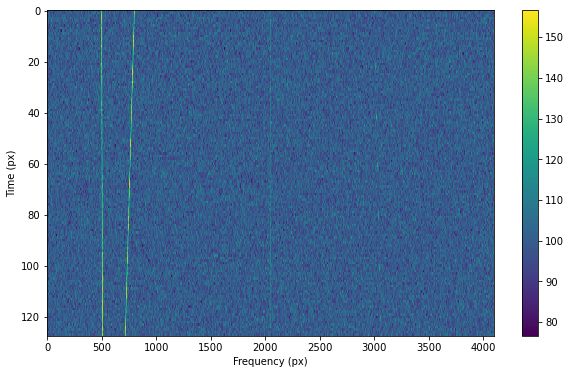

In [6]:
metadata = {'fch1': 6095.214842353016*u.MHz, 
            'dt': 18.25361108*u.s, 
            'df': 2.7939677238464355*u.Hz}

frame = stg.Frame(fchans=2**12*u.pixel,
                  tchans=128*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

test_tones = [
  {'f_start': frame.get_frequency(index=500), 'drift_rate': 0.01*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=800), 'drift_rate': -0.10*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=2048), 'drift_rate': 0.00*u.Hz/u.s, 'snr': 20, 'width': 6*u.Hz},
  {'f_start': frame.get_frequency(index=3000), 'drift_rate': 0.07*u.Hz/u.s, 'snr': 50, 'width': 3*u.Hz}
]

noise = frame.add_noise(x_mean=100, x_std=5, noise_type='gaussian')

for tone in test_tones:
    signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

fig = plt.figure(figsize=(10, 6))
frame.render()

pd.DataFrame(test_tones)

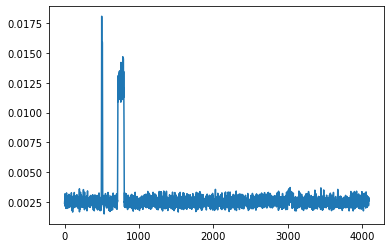

In [7]:
sc = spectral_kurtosis(frame.data, return_space='cpu')
plt.plot(sc)

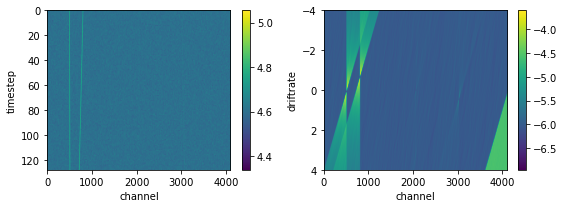

In [8]:
from hyperseti import dedoppler, H5Reader
from plotting import imshow_waterfall, imshow_dedopp

test_data = frame.data
metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}

dedopp_sk, metadata = dedoppler(test_data, metadata, boxcar_size=1, max_dd=4.0, kernel='kurtosis')


# Imshow output
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
imshow_waterfall(np.log(test_data), metadata)
plt.subplot(1,2,2)
imshow_dedopp(np.log(dedopp_sk), metadata)
plt.tight_layout()

In [33]:
fn = '/datax/collate_mb/PKS_0262_2018-02-21T17:00/blc01/guppi_58171_08035_757812_G26.37-1.21_0001.0000.hires.hdf'
gulp_size = 2**12

h5 = H5Reader(fn, gulp_size=gulp_size) 
gulp_metadata = h5.generate_gulp_metadata()
md = next(gulp_metadata)



{'fch1': <Quantity 1513.43554688 MHz>, 'dt': <Quantity 19.17396114 s>, 'df': <Quantity -3.33786011 Hz>, 'i0': 94208, 'i1': 98304, 'sidx': 23}


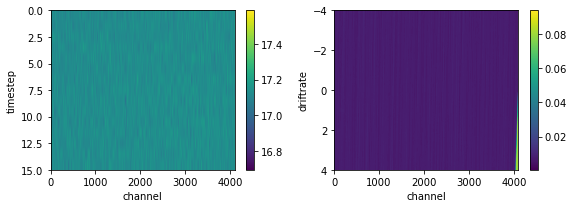

In [57]:
md = next(gulp_metadata)
print(md)
d = h5.read_data(md)

dedopp, metadata = dedoppler(d, metadata, boxcar_size=1, max_dd=4.0, kernel='kurtosis')


# Imshow output
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
imshow_waterfall(np.log(d), metadata)
plt.subplot(1,2,2)
imshow_dedopp(dedopp, metadata)
plt.tight_layout()

In [58]:
import h5py
H = h5py.File(fn)

In [60]:
np.argmax(H['data'][0])

13107200

In [64]:
D = H['data'][:, 0, 13107200-200:13107200+200]

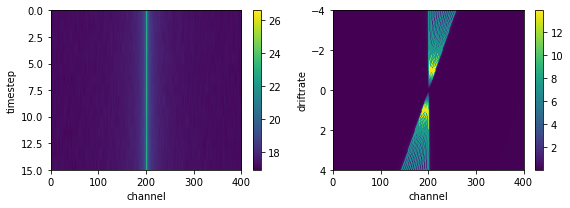

In [66]:
dedopp, metadata = dedoppler(D, metadata, boxcar_size=1, max_dd=4.0, kernel='kurtosis')


# Imshow output
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
imshow_waterfall(np.log(D), metadata)
plt.subplot(1,2,2)
imshow_dedopp(dedopp, metadata)
plt.tight_layout()